In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.optim as optim
from twa.utils import ensure_dir, write_yaml, read_yaml, glob_re
from twa.data import FlowSystemODE, topo_point_vs_cycle
from twa.evaluate import Evaluator
from sklearn.decomposition import PCA
import random
random.seed(0)
torch.manual_seed(0)

outdir = '../output/'

def rm_suffix(s, suffix):
    if len(suffix) > 0 and (suffix in s):
        return s.split(suffix)[0]
    return s

# Results

## Benchmark comparison

In [2]:
# configs for Table 1 (noise=0.1)

# compared models
exp_descs = {} 
exp_descs['simple_oscillator_nsfcl_angle_atten_AttentionwFC'] = 'Our Model'
exp_descs['critical_points'] = 'Critical Points'
# exp_descs['lyapunov'] = 'Lyapunov' # run separately since it was evaluated on datatraj dataset
exp_descs['p2v_linear'] = 'Phase2Vec'
exp_descs['vfpoly_linear'] = 'Autoencoder'
exp_descs['params_linear'] = 'Parameters'

# compared systems
noise = 0 # 0.1
noise_desc = f'_noise{noise}' if noise > 0 else ''

sys_descs = {}
sys_descs['simple_oscillator_noaug' + noise_desc] = 'SO'
sys_descs['simple_oscillator_nsfcl' + noise_desc] = 'Augmented SO'
sys_descs['suphopf' + noise_desc] = 'Supercritical Hopf'
# sys_descs['subhopf' + noise_desc] = 'Subcritical Hopf'
sys_descs['lienard_poly' + noise_desc] = 'Lienard Poly'
sys_descs['lienard_sigmoid' + noise_desc] = 'Lienard Sigmoid'
sys_descs['vanderpol' + noise_desc] = 'Van der Pol'
sys_descs['bzreaction' + noise_desc] = 'BZ Reaction'
sys_descs['selkov2' + noise_desc] = 'Sel\'kov'

selected_syss = list(sys_descs.keys()) # classical synthetic systems
print(selected_syss)

sys_descs['repressilator'] = 'Repressilator'
sys_descs['pancreas_clusters_random_bin'] = 'Pancreas'


# setting ground truth dataset
sys_gt_descs = {k: rm_suffix(k, suffix=noise_desc) for k in sys_descs.keys()}

# setting 
ode_syss = {k: rm_suffix(k, suffix=noise_desc) for k in sys_descs.keys()}
ode_syss['simple_oscillator_noaug' + noise_desc] = 'simple_oscillator'
ode_syss['simple_oscillator_nsfcl' + noise_desc] = 'simple_oscillator'
ode_syss['selkov2' + noise_desc] = 'selkov'
ode_syss['pancreas_clusters_random_bin' + noise_desc] = None


# evaluator
EV = Evaluator(exp_descs=exp_descs, sys_descs=sys_descs, sys_gt_descs=sys_gt_descs, ode_syss=ode_syss, verbose=False, outdir=outdir)

['simple_oscillator_noaug', 'simple_oscillator_nsfcl', 'suphopf', 'lienard_poly', 'lienard_sigmoid', 'vanderpol', 'bzreaction', 'selkov2']
Error loading dists for  repressilator


In [3]:
# average accuracies across repeats
print('Accuracy with noise={}'.format(noise))
res = EV.get_stats(syss=selected_syss, stats=['Accu'])
# res = EV.get_stats(syss=selected_syss, stats=['Accu', 'Sens', 'Spec'])
print(res)
# EV.print_stat(syss=selected_syss) # for latex table

Accuracy with noise=0
                          SO  Augmented SO  Supercritical Hopf  Lienard Poly  \
                                                                               
Our Model       Accu  0.9742        0.9266              0.9852        0.8746   
Critical Points Accu  1.0000        0.9300              1.0000        0.9700   
Phase2Vec       Accu  0.8766        0.8534              0.9040        0.4970   
Autoencoder     Accu  0.9372        0.8686              0.9654        0.6376   
Parameters      Accu  0.5400        0.5256              0.5708        0.5194   

                      Lienard Sigmoid  Van der Pol  BZ Reaction  Sel'kov  \
                                                                           
Our Model       Accu           0.9186       0.8474       0.8274   0.6574   
Critical Points Accu           1.0000       1.0000       0.7000   0.9200   
Phase2Vec       Accu           0.4816       0.5068       0.5000   0.4900   
Autoencoder     Accu           0.8956

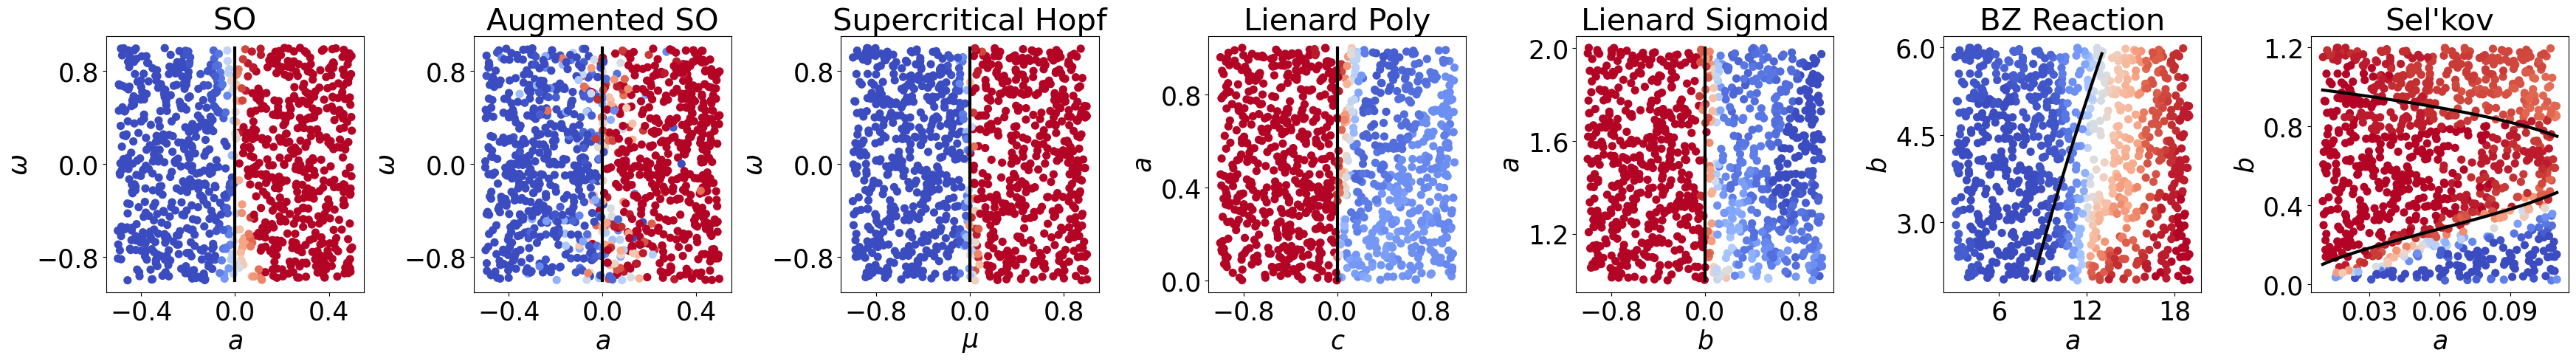

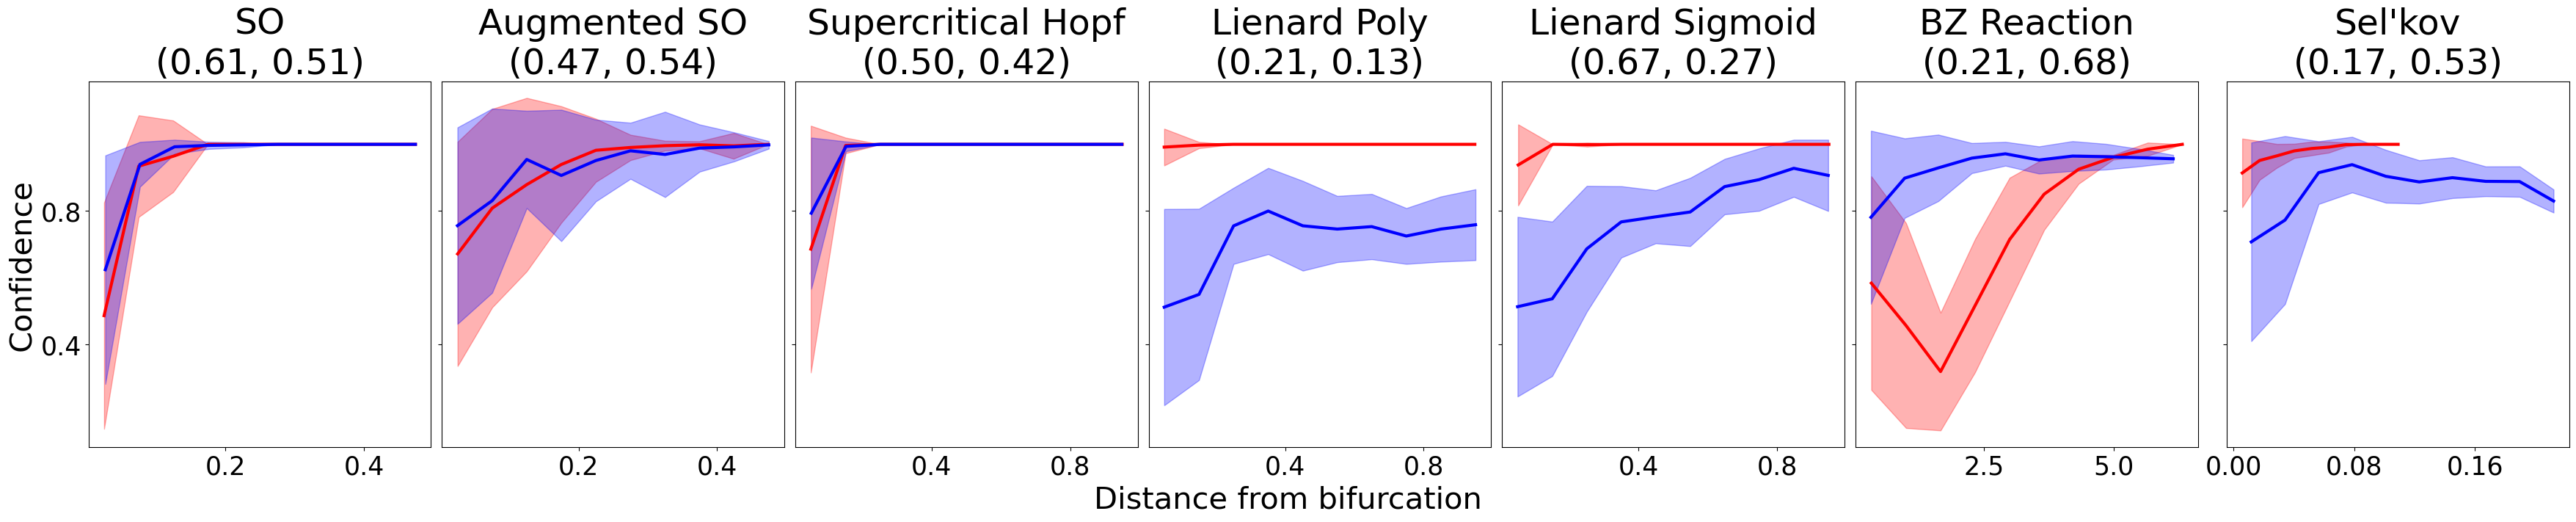

In [4]:
# plotting confidence
exp = 'simple_oscillator_nsfcl_angle_atten_AttentionwFC'
sselected_syss = [s for s in selected_syss if not s.startswith('vanderpol')] # exclude vanderpol because of single parameter

EV.plot_bifurcation(exp, syss=sselected_syss, verbose=False)
EV.plot_dist_from_bifur(exp, syss=sselected_syss, verbose=False)

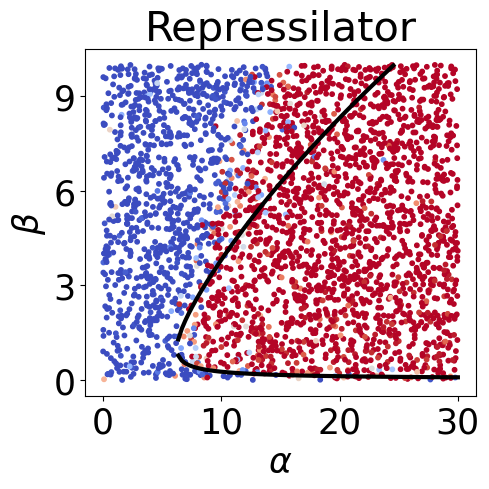

In [5]:
# repressilator prediction
EV.plot_bifurcation(exp, syss=['repressilator'], s=10)

Accuracy for pancreas
                      Pancreas  Average
                                       
Our Model       Accu     0.944    0.944
Critical Points Accu     0.540    0.540
Phase2Vec       Accu     0.300    0.300
Autoencoder     Accu     0.300    0.300
Parameters      Accu       NaN      NaN
Corr: 0.8651664480091869


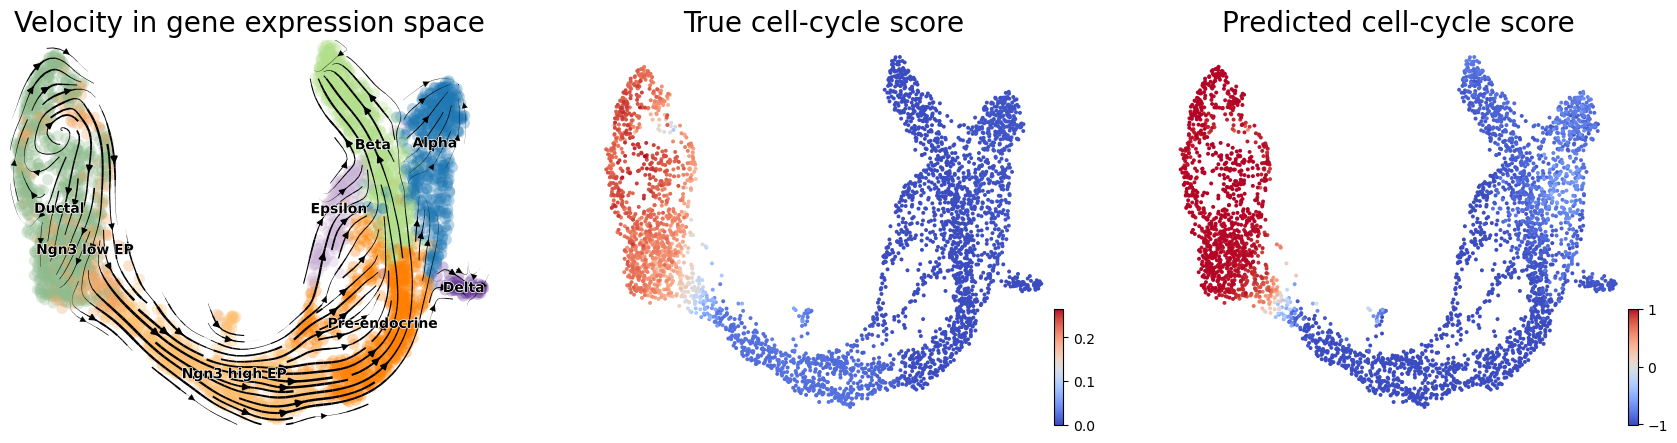

In [6]:
# average accuracies across repeats
print('Accuracy for pancreas')
res = EV.get_stats(syss=['pancreas_clusters_random_bin'], stats=['Accu'])
print(res)
# EV.print_stat(syss=['pancreas_clusters_random_bin']) # for latex table

# plot pancreas predicted cycle scores
EV.plot_pancreas(exp)

## Noise evaluation

In [7]:
# Table 2 - evaluation of varied noise levels
noises = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sys_descs_noises = {f'simple_oscillator_nsfcl_noise{noise:.02f}': noise for noise in noises}
sys_descs_noises[f'simple_oscillator_nsfcl'] = 0.0
sys_gt_descs_noises = {k: rm_suffix(k, suffix='_noise') for k in sys_descs_noises.keys()}
ode_syss_noises = {k: 'simple_oscillator' for k in sys_descs_noises.keys()}

# evaluator
EV_noises = Evaluator(exp_descs=exp_descs, sys_descs=sys_descs_noises, sys_gt_descs=sys_gt_descs_noises, ode_syss=ode_syss_noises, verbose=False, outdir=outdir)

# average accuracies across repeats
print('Accuracy with varying noise for Augmented SO')
res = EV_noises.get_stats(stats=['Accu'])
print(res)


Accuracy with varying noise for Augmented SO
                           0.1       0.2       0.3       0.4       0.5  \
                                                                         
Our Model       Accu  0.926200  0.925600  0.910600  0.862200  0.782000   
Critical Points Accu  0.550000  0.540000  0.530000  0.520000  0.520000   
Phase2Vec       Accu  0.708200  0.536200  0.509000  0.500400  0.500000   
Autoencoder     Accu  0.867674  0.838605  0.798372  0.771163  0.731628   
Parameters      Accu  0.526000  0.524800  0.524200  0.526600  0.520800   

                           0.6       0.7       0.8       0.9       1.0  \
                                                                         
Our Model       Accu  0.695800  0.635000  0.591400  0.562400  0.540400   
Critical Points Accu  0.500000  0.500000  0.500000  0.500000  0.500000   
Phase2Vec       Accu  0.500000  0.500000  0.500000  0.500000  0.500000   
Autoencoder     Accu  0.706047  0.681628  0.663023  0.641163  0.63

## Hyperparameter and architecture alternatives

In [11]:
# Table A4
exp_descs_params = {} 
exp_descs_params['simple_oscillator_nsfcl_angle_atten_AttentionwFC'] = 'Our Model'
exp_descs_params['simple_oscillator_nsfcl_angle_atten_AttentionwFC_lr3'] = 'Our Model lr3'
exp_descs_params['simple_oscillator_nsfcl_angle_atten_AttentionwFC_lr5'] = 'Our Model lr5'
exp_descs_params['simple_oscillator_nsfcl_angle_atten_AttentionwFC_ne10'] = 'Our Model ne10'
exp_descs_params['simple_oscillator_nsfcl_angle_atten_AttentionwFC_ne40'] = 'Our Model ne40'

exp_descs_params['critical_points'] = 'Critical Points'
# exp_descs_params['lyapunov'] = 'Lyapunov' # run separately since it was evaluated on datatraj dataset

exp_descs_params['p2v_linear'] = 'Phase2Vec'
exp_descs_params['p2v_linear_lr3'] = 'Phase2Vec lr3'
exp_descs_params['p2v_linear_lr5'] = 'Phase2Vec lr5'
exp_descs_params['p2v_linear_ne10'] = 'Phase2Vec ne10'
exp_descs_params['p2v_linear_ne40'] = 'Phase2Vec ne40'

exp_descs_params['vfpoly_linear'] = 'Autoencoder'
exp_descs_params['vfpoly_linear_lr3'] = 'Autoencoder lr3'
exp_descs_params['vfpoly_linear_lr5'] = 'Autoencoder lr5'
exp_descs_params['vfpoly_linear_ne10'] = 'Autoencoder ne10'
exp_descs_params['vfpoly_linear_ne40'] = 'Autoencoder ne40'

exp_descs_params['params_linear'] = 'Parameters'
exp_descs_params['params_linear_lr3'] = 'Parameters lr3'
exp_descs_params['params_linear_lr5'] = 'Parameters lr5'
exp_descs_params['params_linear_ne10'] = 'Parameters ne10'
exp_descs_params['params_linear_ne40'] = 'Parameters ne40'


EV_params = Evaluator(exp_descs=exp_descs_params, sys_descs=sys_descs, sys_gt_descs=sys_gt_descs, ode_syss=ode_syss, verbose=False, outdir=outdir)

res = EV_params.get_stats(syss=selected_syss, stats=['Accu'])
print(res)
# EV_params.print_stat(syss=selected_syss) # for latex table

Error loading dists for  repressilator
                           SO  Augmented SO  Supercritical Hopf  Lienard Poly  \
                                                                                
Our Model        Accu  0.9742        0.9266              0.9852        0.8746   
Our Model lr3    Accu  0.9512        0.9100              0.9650        0.8356   
Our Model lr5    Accu  0.9688        0.8592              0.9818        0.8830   
Our Model ne10   Accu  0.9688        0.9190              0.9850        0.8794   
Our Model ne40   Accu  0.9754        0.9276              0.9832        0.8630   
Critical Points  Accu  1.0000        0.9300              1.0000        0.9700   
Phase2Vec        Accu  0.8766        0.8534              0.9040        0.4970   
Phase2Vec lr3    Accu  0.8970        0.8712              0.9308        0.6052   
Phase2Vec lr5    Accu  0.8512        0.7336              0.9414        0.4700   
Phase2Vec ne10   Accu  0.8078        0.8218              0.9100       

In [15]:
# ablations
exp_descs_ablate = {}
exp_descs_ablate['simple_oscillator_nsfcl_angle_atten_AttentionwFC'] = 'Our Model'
exp_descs_ablate['simple_oscillator_nsfcl_angle_noatten_AttentionwFC'] = 'No Attention'
exp_descs_ablate['simple_oscillator_nsfcl_vector_atten_AttentionwFC'] = 'From Vectors'
exp_descs_ablate['simple_oscillator_noaug_angle_atten_AttentionwFC'] = 'No Augmentation'

exp_descs_ablate['simple_oscillator_noaug_vector_noatten_AttentionwFC'] = 'CNN-baseline'

EV_ablate = Evaluator(exp_descs=exp_descs_ablate, sys_descs=sys_descs, ode_syss=ode_syss, outdir=outdir)

res = EV_ablate.get_stats(syss=selected_syss, stats=['Accu'])
print(res)
# EV_ablate.print_stat(syss=selected_syss) # for latex table

Error loading dists for  repressilator
                          SO  Augmented SO  Supercritical Hopf  Lienard Poly  \
                                                                               
Our Model       Accu  0.9742        0.9266              0.9852        0.8746   
No Attention    Accu  0.9720        0.9196              0.9764        0.6258   
From Vectors    Accu  0.9694        0.9152              0.9776        0.5984   
No Augmentation Accu  0.9938        0.4542              0.9880        0.9434   
CNN-baseline    Accu  0.9836        0.5476              0.9864        0.5862   

                      Lienard Sigmoid  Van der Pol  BZ Reaction  Sel'kov  \
                                                                           
Our Model       Accu           0.9186       0.8474       0.8274   0.6574   
No Attention    Accu           0.6576       0.5330       0.8382   0.6166   
From Vectors    Accu           0.9618       0.9324       0.6178   0.5748   
No Augmentation Accu

In [16]:
# architecure variations
exp_descs_arch = {} 
exp_descs_arch['simple_oscillator_nsfcl_angle_atten_AttentionwFC'] = 'Our Model'
exp_descs_arch['dropout5'] = 'dropout = 0.5'
exp_descs_arch['kernel5'] = 'kernel size = 5'
exp_descs_arch['latent5'] = 'latent dimension = 5'
exp_descs_arch['latent20'] = 'latent dimension = 20'
exp_descs_arch['channels32'] = 'conv channels = 32'
exp_descs_arch['conv3'] = 'conv layers = 3'

EV_arch = Evaluator(exp_descs=exp_descs_arch, sys_descs=sys_descs, sys_gt_descs=sys_gt_descs, ode_syss=ode_syss, verbose=False, outdir=outdir)

res = EV_arch.get_stats(syss=selected_syss, stats=['Accu'])
print(res)
# EV_arch.print_stat(syss=selected_syss) # for latex table

Error loading dists for  repressilator
                                SO  Augmented SO  Supercritical Hopf  \
                                                                       
Our Model             Accu  0.9742        0.9266              0.9852   
dropout = 0.5         Accu  0.9750        0.9254              0.9824   
kernel size = 5       Accu  0.9728        0.9230              0.9818   
latent dimension = 5  Accu  0.9770        0.9268              0.9858   
latent dimension = 20 Accu  0.9738        0.9258              0.9836   
conv channels = 32    Accu  0.9792        0.9226              0.9854   
conv layers = 3       Accu  0.9728        0.9240              0.9834   

                            Lienard Poly  Lienard Sigmoid  Van der Pol  \
                                                                         
Our Model             Accu        0.8746           0.9186       0.8474   
dropout = 0.5         Accu        0.8390           0.9342       0.8028   
kernel size = 5 